# Encoders and Privacy Metrics
Exploring the effects of encoding methods on privacy metrics.

Stemmed from an issue where we noticed that uniform had lower DCR/NNDR (higher privacy risk) than generators.

## Load libraries and define settings

In [157]:
# general dependencies
import numpy as np
import pandas as pd
import sys
import os
from pathlib import Path

# synthesis methods
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.benchmark import Benchmarks

from synthesis.synthesizers.privbayes import PrivBayes
from synthesis.evaluation.metrics import MarginalComparison, AssociationsComparison

# repo code
from crnsynth.configs import config
from crnsynth.synth.custom_generators.privbayes_dk import PrivBayesDK
from crnsynth.synth.custom_generators.marginal_dk import MarginalDK
from crnsynth.synth.custom_generators.uniform_dk import UniformDK

from crnsynth.process import util
from crnsynth.evaluation import visual
from crnsynth.synth.synthpipe import BaseSynthPipe

# gives extra pandas methods for dataframes: bin_numeric_column, sample_from_binned_column
from synthesis.transformers import deidentification, generalization


In [158]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
# privacy budget for differentially private algorithms
EPSILON = 1

# dataset
DATASET_NAME = 'adult'

## Load and process dataset

In [160]:
df_adult = pd.read_csv(config.PATH_DATA[DATASET_NAME])
df_adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Generate
Here we show how step by step how to generate synthetic data.

We define our synthesis pipeline, this will help us perform all the steps the right order. You can inherit common functionality across synthesis pipelines, while also adding your own data-specific methods to it. 

This ensures that you can benefit from a defined structure without needing to re-implement the generic elements, while still having the flexbility to customize it to your needs.

In [161]:
class AdultSynthPipe(BaseSynthPipe):
    def __init__(
        self,
        generator,
        data_name="adult",
        target_column="income",
        test_size=0.2,
        output_train_format=False,
        generalize=True,
        data_loader_name="generic",
        random_state=None,
        warn=True,
        verbose=2,
    ) -> None:
        super().__init__(
            generator=generator,
            data_name=data_name,
            target_column=target_column,
            test_size=test_size,
            output_train_format=output_train_format,
            generalize=generalize,
            data_loader_name=data_loader_name,
            random_state=random_state,
            warn=warn,
            verbose=verbose,
        )

    def process_data(self, data_real):
        # reduce columns
        columns_subset = [
            "age",
            "workclass",
            "education",
            "marital-status",
            "occupation",
            "relationship",
            "race",
            "sex",
            "hours-per-week",
            "native-country",
            "income",
        ]
        data_real = data_real[columns_subset]

        return super().process_data(data_real)

    def _generalize_data(self, data_real):
        data_real = data_real.bin_numeric_column(
            column_name="age", n_bins=5, col_min=17, col_max=90, strategy="quantile"
        ).bin_numeric_column(
            column_name="hours-per-week",
            n_bins=5,
            col_min=1,
            col_max=99,
            strategy="quantile",
        )
        return super()._generalize_data(data_real)

    def _reverse_generalization(self, data_synth):
        data_synth = data_synth.sample_from_binned_column(
            column_name="age",
            numeric_type="int",
            mean=38,
            std=13,
            random_state=self.random_state,
        ).sample_from_binned_column(
            column_name="hours-per-week",
            numeric_type="int",
            mean=40,
            std=10,
            random_state=self.random_state,
        )
        return super()._reverse_generalization(data_synth)


# choose generator
# generator = Plugins().get('privbayes-dk', epsilon=EPSILON)
generator = Plugins().get('uniform_sampler_custom', epsilon=EPSILON)

# initialize custom pipeline for dataset
synth_pipe = AdultSynthPipe(generator=generator, random_state=42)

[2024-01-15T19:53:57.747575+0100][1546][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py


Now we will prepare the data and split into training and testing. It's good to leave some holdout data that that can be used to compare the perfomance of models trained on real data and synthetic data.

In [17]:
# create copy to retain original data format
df = df_adult.copy()

# prepare data
df_train, df_test = synth_pipe.process_data(df)
df_train.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
15738,32,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,45,United-States,>50K
27985,43,Private,Masters,Never-married,Exec-managerial,Not-in-family,White,Female,45,United-States,<=50K
30673,20,?,HS-grad,Never-married,?,Not-in-family,White,Female,28,United-States,<=50K
9505,40,Local-gov,Some-college,Divorced,Transport-moving,Unmarried,White,Male,40,United-States,<=50K
26417,24,Private,Bachelors,Never-married,Prof-specialty,Own-child,White,Male,40,United-States,<=50K


Train the generator on the processed training data. It might give some warning on categoreis that occur quite infrequently and might be a privacy risk to leave in your data. Decide how you would like to deal with them or proceed.

In [18]:
# train generator
synth_pipe.fit(df_train)

Bins whose width are too small (i.e., <= 1e-8). Consider decreasing the number of bins.


Using data loader for generic
Uniform fitted: age
Uniform fitted: workclass
Uniform fitted: education
Uniform fitted: marital-status
Uniform fitted: occupation
Uniform fitted: relationship
Uniform fitted: race
Uniform fitted: sex
Uniform fitted: hours-per-week
Uniform fitted: native-country
Uniform fitted: income


After training the synthesizer, we can now sample records from it to generate a synthetic dataset.

In [19]:
# generate synthetic data
df_synth = synth_pipe.generate(n_records=None)
df_synth.head()

Column sampled: age
Column sampled: workclass
Column sampled: education
Column sampled: marital-status
Column sampled: occupation
Column sampled: relationship
Column sampled: race
Column sampled: sex
Column sampled: hours-per-week
Column sampled: native-country
Column sampled: income


,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,21,?,Bachelors,Never-married,Sales,Wife,Black,Male,52,Mexico,<=50K
1,41,Private,Doctorate,Married-civ-spouse,Transport-moving,Wife,White,Female,35,Columbia,>50K
2,39,?,Bachelors,Separated,Protective-serv,Wife,Amer-Indian-Eskimo,Male,57,England,>50K
3,23,Private,Doctorate,Married-AF-spouse,Transport-moving,Other-relative,White,Female,31,Canada,<=50K
4,19,Local-gov,Masters,Separated,Armed-Forces,Husband,White,Female,36,Puerto-Rico,<=50K


We still might have to do some post-processing to fix inconsistencies, reorder columns or add columns.

In [20]:
# post-process data
df_synth = synth_pipe.postprocess_synthetic_data(df_synth)

df_synth.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,21,?,Bachelors,Never-married,Sales,Wife,Black,Male,52,Mexico,<=50K
1,41,Private,Doctorate,Married-civ-spouse,Transport-moving,Wife,White,Female,35,Columbia,>50K
2,39,?,Bachelors,Separated,Protective-serv,Wife,Amer-Indian-Eskimo,Male,57,England,>50K
3,23,Private,Doctorate,Married-AF-spouse,Transport-moving,Other-relative,White,Female,31,Canada,<=50K
4,19,Local-gov,Masters,Separated,Armed-Forces,Husband,White,Female,36,Puerto-Rico,<=50K


SynthPipe allows you to perform a full synthesis pipeline step by step and allow you to inspect what happens. However, you can also use run() to perform all steps in order at once.

In [11]:
# choose generator
generator = Plugins().get('privbayes-dk', epsilon=EPSILON)

# initialize custom pipeline for dataset
synth_pipe = AdultSynthPipe(generator=generator, output_train_format=True)

df_synth_pb = synth_pipe.run(df_adult)

[2024-01-15T08:42:14.786381+0100][1546][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
Bins whose width are too small (i.e., <= 1e-8). Consider decreasing the number of bins.


Using data loader for generic
1/11 - Root of network: native-country

2/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 10
Selected attribute: 'hours-per-week' - with parents: ('native-country',)

3/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 11
Selected attribute: 'occupation' - with parents: ('hours-per-week',)

4/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 15
Selected attribute: 'workclass' - with parents: ('occupation',)

5/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 18
Selected attribute: 'sex' - with parents: ('occupation', 'hours-per-week')

6/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 20
Selected attribute: 'relationship' - with parents: ('occupation', 'sex')

7/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates

invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


Number of records generated: 26048 / 26048
Synthetic Data Generated

Number of records generated: 26048 / 26048
Synthetic Data Generated



In [44]:
# choose generator
generator = Plugins().get('uniform_sampler_custom', epsilon=EPSILON)

# initialize custom pipeline for dataset
synth_pipe = AdultSynthPipe(generator=generator, output_train_format=True)

df_synth_uniform = synth_pipe.run(df_adult)

[2024-01-15T10:27:37.152884+0100][1546][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
Bins whose width are too small (i.e., <= 1e-8). Consider decreasing the number of bins.


Using data loader for generic
Uniform fitted: age
Uniform fitted: workclass
Uniform fitted: education
Uniform fitted: marital-status
Uniform fitted: occupation
Uniform fitted: relationship
Uniform fitted: race
Uniform fitted: sex
Uniform fitted: hours-per-week
Uniform fitted: native-country
Uniform fitted: income
Column sampled: age
Column sampled: workclass
Column sampled: education
Column sampled: marital-status
Column sampled: occupation
Column sampled: relationship
Column sampled: race
Column sampled: sex
Column sampled: hours-per-week
Column sampled: native-country
Column sampled: income
Column sampled: age
Column sampled: workclass
Column sampled: education
Column sampled: marital-status
Column sampled: occupation
Column sampled: relationship
Column sampled: race
Column sampled: sex
Column sampled: hours-per-week
Column sampled: native-country
Column sampled: income


Note: PrivBayes implementation of synthetic-data-generation library (DK) is added to plugins. This version of privbayes differs with the one included synthcity:
- R score function instead of Mutual Information - which has a lower sensitivity and thus requires less noise to compute.
- Candidate attribute-parent pairs (AP-pairs) are determined based on the theta-usefulness criterion instead of setting a fixed max degree K.

## Metrics
Below an example on how to compute a privacy metric. Note the synthetic score (DCR and NNDR) > test score to minimize privacy leakage.

In [70]:
from crnsynth.evaluation.custom_privacy_metrics.utils import compute_distance_nn
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from synthcity.plugins.core.dataloader import create_from_info

In [110]:
# create encoder dictionary for synthcity
def get_encoder_dict2(df, categorical_cols=None):
    # infer column types
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(exclude=np.number).columns

    # define encoders per column (synthcity requirement)
    encoders = {}

    for col in df.columns:
        if col in categorical_cols:
            encoders[col] = OneHotEncoder(handle_unknown='error')
        else:
            encoders[col] = SimpleImputer(missing_values=np.nan, strategy="median")
            continue

    return encoders

def get_transformer(df, categorical_cols=None):
    # define column types
    if categorical_cols is None:
        categorical_cols = df_train.select_dtypes(exclude=np.number).columns
        numeric_cols = df_train.select_dtypes(include=np.number).columns
    else:
        numeric_cols = df_train.columns.difference(categorical_cols)

    transformer = make_column_transformer(
        (SimpleImputer(missing_values=np.nan, strategy="mean"), numeric_cols),
        (OneHotEncoder(sparse_output=False), categorical_cols), # sparse_ouput = False to convert to pandas
        remainder="passthrough",
    )

    # ensure output is dataframe
    transformer.set_output(transform='pandas')
    return transformer
    

In [71]:
# # one hot encoder
# def custom_encoder(loader_real: GenericDataLoader, loader_synth: GenericDataLoader):
#     categorical_cols = df_train.select_dtypes(exclude=np.number).columns
#     numeric_cols = df_train.select_dtypes(include=np.number).columns

#     # process data before model training
#     transformer = make_column_transformer(
#         (SimpleImputer(missing_values=np.nan, strategy="mean"), numeric_cols),
#         (OneHotEncoder(), categorical_cols),
#         remainder="passthrough",
#     )

#     # run on all data to ensure all categories are encoded
#     transformer.fit(pd.concat([loader_real.dataframe(), loader_synth.dataframe()]))

#     # transform data
#     loader_real_enc = loader_real.from_info(transformer.transform(loader_real.dataframe(), loader_real.info()))
#     loader_synth_enc = create_from_info(transformer.transform(loader_synth.dataframe()), loader_synth.info())
#     return loader_real_enc, loader_synth_enc

In [79]:
get_encoder_dict(loader_real.dataframe())

{'age': SimpleImputer(strategy='median'),
 'workclass': OneHotEncoder(),
 'education': OneHotEncoder(),
 'marital-status': OneHotEncoder(),
 'occupation': OneHotEncoder(),
 'relationship': OneHotEncoder(),
 'race': OneHotEncoder(),
 'sex': OneHotEncoder(),
 'hours-per-week': SimpleImputer(strategy='median'),
 'native-country': OneHotEncoder(),
 'income': OneHotEncoder()}

In [96]:
from sklearn.preprocessing import LabelEncoder
single_col = data_real['sex']
LabelEncoder().fit(single_col)

LabelEncoder()

In [134]:
# def custom_encode(loader, encoders=None):
#     """Run custom encoders on synthcity dataloader.
#     Workaround due to bug, where encoders (other than LabelEncoder) cannot be fit on single columns without re-shaping (pd.Series).
#     Also using OneHotEncoders means that new columns are created, where synthcity aims to keep the same columns as the original dataset.
#     """
#     df_encoded = loader.dataframe().copy()

#     # fit encoders on data
#     if encoders is None:
#         encoders = get_encoder_dict(df_encoded)
#         for col in encoders:
#             # run on single column as dataframe using double brackets [[]]
#             encoders[col].fit(df_encoded[[col]])

    
#     # transform data
#     for col in encoders:
#         # run on single column as dataframe using double brackets [[]]
#         df_encoded[col] = encoders[col].transform(df_encoded[[col]])
    
#     # convert back to dataloader
#     loader_enc = loader.from_info(df_encoded, loader.info())
#     return loader_enc, encoders


def custom_encode(loader, encoders=None):
    """Run custom encoders on synthcity dataloader, as their implementation does not work with anything other than LabelEncoders.
    """
    df = loader.dataframe().copy()

    # fit encoders on data
    if encoders is None:
        encoders = get_transformer(df)
        encoders.fit(df)

    # transform data
    df_encoded = encoders.transform(df)
    loader_enc = GenericDataLoader(df_encoded)
    return loader_enc, encoders
    



# convert to dataloaders
loader_real = GenericDataLoader(df_train, random_state=42)
loader_synth_uniform = GenericDataLoader(df_synth_uniform, random_state=42)
loader_synth_pb = GenericDataLoader(df_synth_pb, random_state=42)

# encoding methods native (synthcity) vs custom
loaders_synth = [loader_synth_uniform, loader_synth_pb]
algorithm_names = ['uniform', 'privbayes']
encoding_methods = ['custom', 'native', 'native_refit']

distances = {}


# compute stats per synthetic dataset
for name, loader_synth in zip(algorithm_names, loaders_synth):
    distances[name] = {}

    for encoding_method in encoding_methods:
        print(f"Algorithm: {name} and encoding_method: {encoding_method}")

        # standard synthcity encoding using labelencoder
        if encoding_method == 'native':
            # fit and transform encoders on real
            loader_real_enc, encoders = loader_real.encode(encoders=None)

            # use fitted transformer to encode synth data 
            loader_synth_enc, _ = loader_synth.encode(encoders=encoders)

        elif encoding_method == 'custom':
            loader_real_enc, encoders = custom_encode(loader_real, encoders=None)
            loader_synth_enc, _ = custom_encode(loader_synth, encoders=encoders)
        
        elif encoding_method == 'native_refit':
            # old way of fitting encoders on real and synth data
            loader_real_enc, encoders = loader_real.encode(encoders=None)

            # use fitted transformer to encode synth data 
            loader_synth_enc, _ = loader_synth.encode(encoders=None)

        else:
            raise ValueError(f"unknown encoding method: {encoding_method}")


        distances_test, distances_synth = compute_distance_nn(
            df_train=loader_real_enc.train().dataframe(),
            df_test=loader_real_enc.test().dataframe(),
            df_synth=loader_synth_enc.dataframe(),
        )

        distances[name][encoding_method] = {
            'test': distances_test,
            'synth': distances_synth
        }

Algorithm: uniform and encoding_method: custom
Algorithm: uniform and encoding_method: native
Algorithm: uniform and encoding_method: native_refit
Algorithm: privbayes and encoding_method: custom
Algorithm: privbayes and encoding_method: native
Algorithm: privbayes and encoding_method: native_refit


In [144]:
loader_synth.dataframe().shape

(26048, 11)

In [39]:
from crnsynth.evaluation.custom_privacy_metrics.dcr import DistanceClosestRecord
from crnsynth.evaluation.custom_privacy_metrics.nndr import NearestNeighborDistanceRatio

# convert to dataloaders
loader_train = GenericDataLoader(df_train, random_state=42)
loader_synth = GenericDataLoader(df_synth, random_state=42)
loader_synth_pb = GenericDataLoader(df_synth_pb, random_state=42)

# encode
loader_train = loader_train.encode()[0]
loader_synth = loader_synth.encode()[0]
loader_synth_pb = loader_synth_pb.encode()[0]

# calculate metrics
# specify percentile for DCR, default is 5 (5th percentile) as we are most interested in distance of the closest records.
# set to 50 for median
quantile = 0.05
dcr = DistanceClosestRecord(quantile=quantile).evaluate(X_gt=loader_train, X_syn=loader_synth)
dcr_pb = DistanceClosestRecord(quantile=quantile).evaluate(X_gt=loader_train, X_syn=loader_synth_pb)

print(f"DCR test: {dcr['gt']:.3f}")
print(f"DCR synthetic: {dcr['syn']:.3f}")
print(f"DCR synthetic PB: {dcr_pb['syn']:.3f}")

nndr = NearestNeighborDistanceRatio(quantile=quantile).evaluate(X_gt=loader_train, X_syn=loader_synth)
nndr_pb = NearestNeighborDistanceRatio(quantile=quantile).evaluate(X_gt=loader_train, X_syn=loader_synth_pb)
print(f"NNDR test: {nndr['gt']:.3f}")
print(f"NNDR synthetic: {nndr['syn']:.3f}")
print(f"NNDR synthetic PB: {nndr_pb['syn']:.3f}")

DCR test: 0.000
DCR synthetic: 0.500
DCR synthetic PB: 0.469
NNDR test: 0.000
NNDR synthetic: 0.708
NNDR synthetic PB: 0.667




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating you

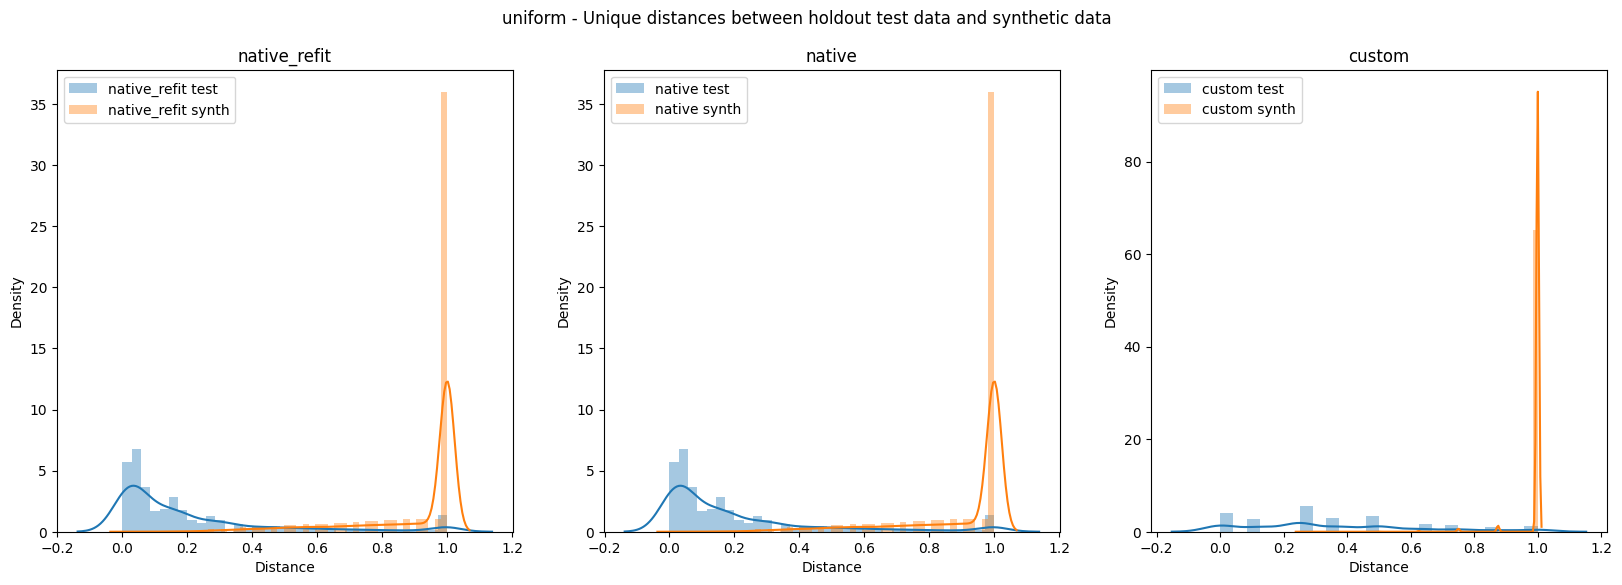

In [151]:
def plot_all_distances(distances, order, title_suffix=None):
    n_plots = len(distances)
    fig, ax = plt.subplots(1, n_plots, figsize=(20, 6))

    # plot unique distances

    for i, encoding_method in enumerate(order):
        sns.distplot(distances[encoding_method]['test'][:, 0], ax=ax[i], label=f'{encoding_method} test')
        sns.distplot(distances[encoding_method]['synth'][:, 0], ax=ax[i], label=f'{encoding_method} synth')

        ax[i].legend()
        ax[i].set_title(f"{encoding_method}")
        ax[i].set_xlabel("Distance")
        ax[i].set_ylabel("Density")

    # title
    fig.suptitle(f"{title_suffix} - Unique distances between holdout test data and synthetic data")
    plt.show()

# include keys
order = ['native_refit', 'native', 'custom']
algorithm = 'uniform'
plot_all_distances(distances[algorithm], order=order, title_suffix=algorithm)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating you

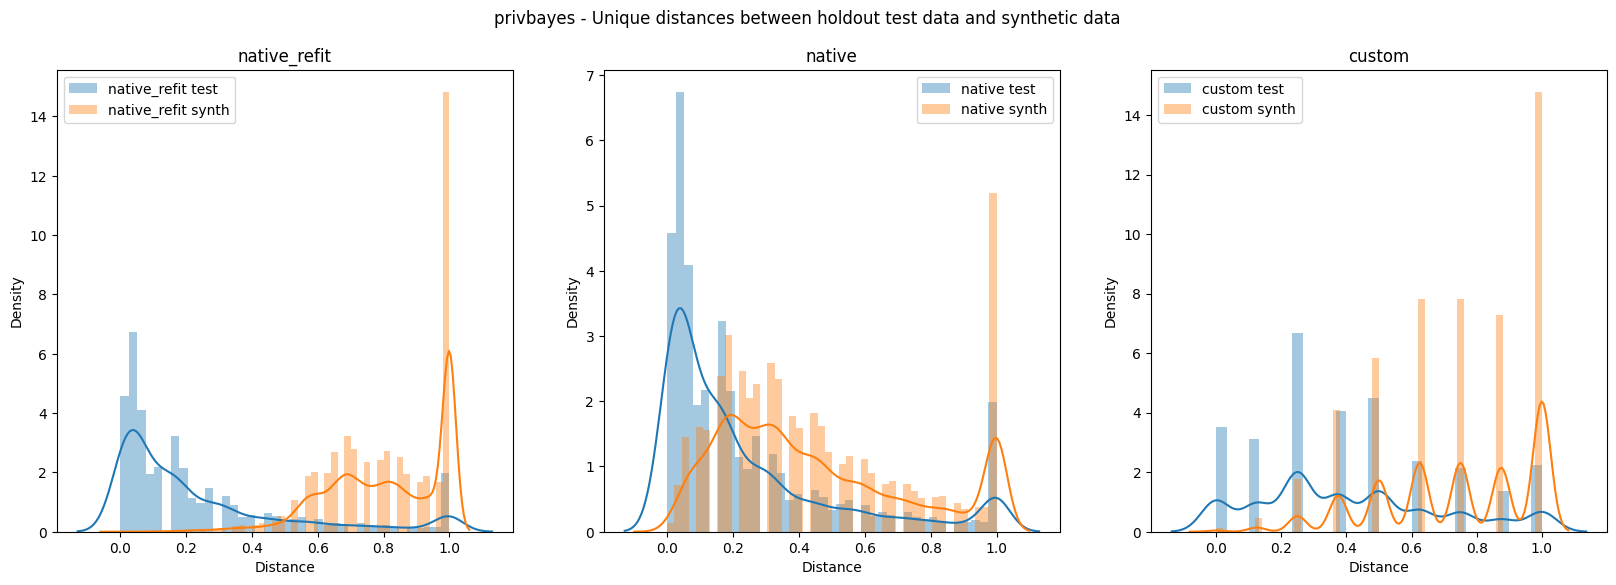

In [142]:
algorithm = 'privbayes'
plot_all_distances(distances[algorithm], order=order, title_suffix=algorithm)

Test distances [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] with counts [  58  155  851 1968 3623 5697 5642 5683 8884]
Synthetic distances: [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] with counts [  58  155  851 1968 3623 5697 5642 5683 8884]




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Text(0.5, 1.0, 'Distribution of distances to nearest neighbor')

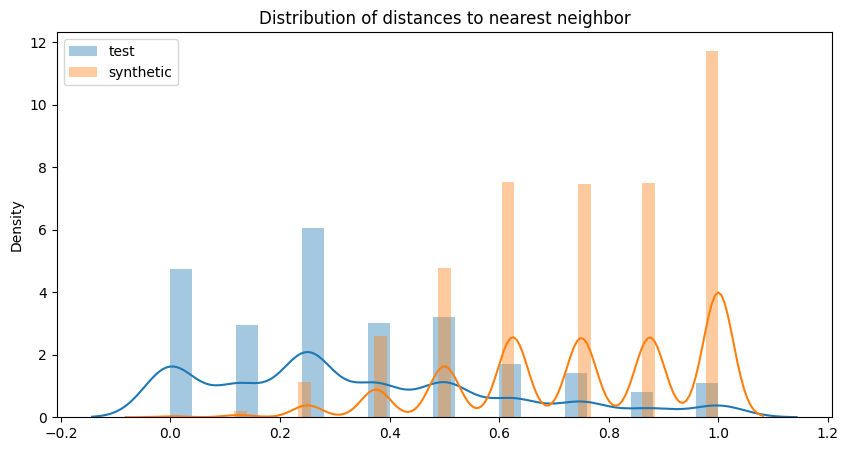

In [62]:
from crnsynth.evaluation.custom_privacy_metrics.utils import compute_distance_nn
import matplotlib.pyplot as plt
import seaborn as sns

distances_test, distances_synth = compute_distance_nn(
    df_train=df_train,
    df_test=df_test,
    df_synth=df_synth,
    categorical_cols=None,
)

# print distances test and synthetic with counts
dt, ct  = np.unique(distances_test[:, 0], return_counts=True)
dt, ct = np.unique(distances_synth[:, 0], return_counts=True)


print(f'Test distances {dt} with counts {ct}')
print(f'Synthetic distances: {dt} with counts {ct}')

# plot distances as distribution in same figure
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(distances_test[:, 0], ax=ax, label='test')

# plot 5th percentile  and median test
percentile_test = np.percentile(distances_test[:, 0], percentile)
median_test = np.median(distances_test[:, 0])
ax.axvline(percentile_test, color='red', label=f'{percentile}th percentile')
ax.axvline(median_test, color='green', label='median')

sns.distplot(distances_synth[:, 0], ax=ax, label='synthetic')
# plot median synthetic
median_synth = np.median(distances_synth[:, 0])

ax.legend()
ax.set_title(f'Distribution of distances to nearest neighbor')

In [26]:
distances_synth

array([[0.875, 1.   ],
       [0.625, 0.75 ],
       [0.375, 0.375],
       ...,
       [0.75 , 0.875],
       [0.5  , 0.625],
       [0.375, 0.375]])

In [27]:
distances_test

array([[0.   , 0.125],
       [1.   , 1.   ],
       [0.375, 0.625],
       ...,
       [0.875, 0.875],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ]])

In [32]:
np.percentile(distances_test[:, 0], 50)

0.25

In [37]:
np.percentile(distances_synth[:, 0], 50)

0.7499999999999998

In [39]:
np.unique(distances_test[:, 0], return_counts=True)

(array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
 array([1240,  766, 1576,  788,  836,  441,  372,  207,  287]))

In [48]:
df_concat_unique = pd.concat([df_train.drop_duplicates(keep=False), df_test])
df_dup = df_concat_unique[df_concat_unique.duplicated(keep='first')]

In [49]:
df_dup

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
13077,57,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,40,United-States,<=50K
21997,34,Private,HS-grad,Divorced,Machine-op-inspct,Unmarried,White,Female,40,United-States,<=50K
22684,54,Private,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,>50K
8964,22,Private,Bachelors,Never-married,Exec-managerial,Not-in-family,White,Female,30,United-States,<=50K
8215,22,Private,HS-grad,Never-married,Other-service,Own-child,White,Female,35,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
24643,53,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,46,United-States,>50K
7672,33,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,<=50K
14344,19,?,Some-college,Never-married,?,Own-child,White,Female,40,United-States,<=50K
8270,43,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,50,United-States,>50K
